<a href="https://colab.research.google.com/github/meetptl04/ImageStyleTranfer/blob/main/imgstyletransfer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Verifying Base Image:
Image shape: (974, 1400, 3)


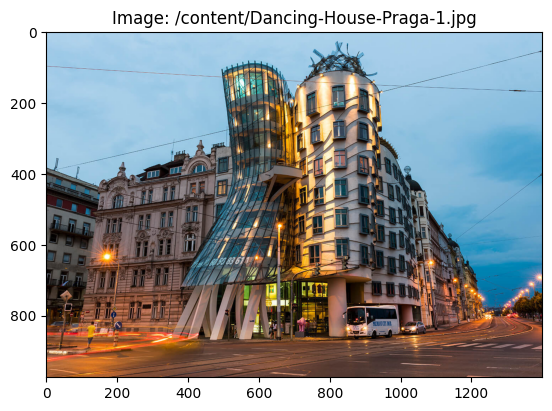

Verifying Style Image:
Image shape: (3648, 5472, 3)


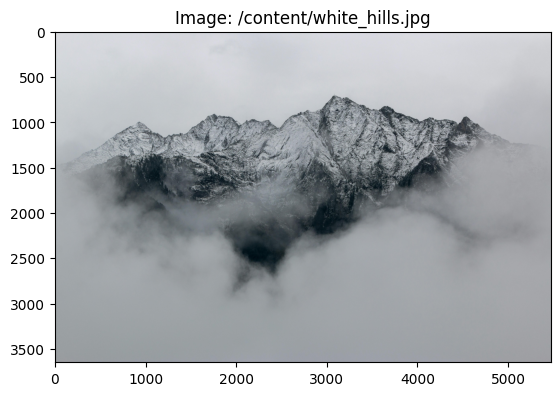

Iteration 0, Loss: 641334272.0
Gradients: 5887.61962890625
Iteration 10, Loss: 625173760.0
Gradients: 5763.3955078125
Iteration 20, Loss: 609575104.0
Gradients: 5642.4169921875
Iteration 30, Loss: 594575936.0
Gradients: 5566.47998046875
Iteration 40, Loss: 580208128.0
Gradients: 5439.4501953125
Iteration 50, Loss: 566441152.0
Gradients: 5417.0732421875
Iteration 60, Loss: 553227328.0
Gradients: 5362.6748046875
Iteration 70, Loss: 540522752.0
Gradients: 5267.66943359375
Iteration 80, Loss: 528290880.0
Gradients: 5154.8125
Iteration 90, Loss: 516505824.0
Gradients: 5085.35205078125


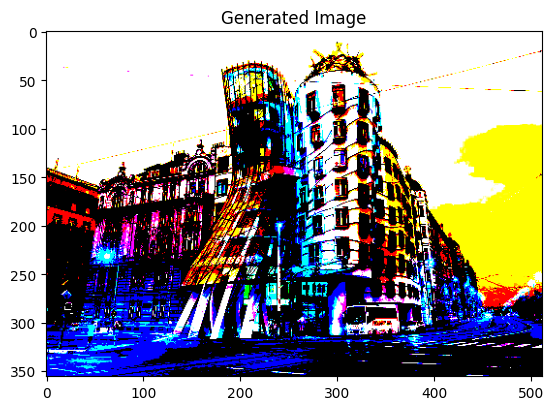

In [6]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

class StyleTransfer:
    def __init__(self, base_image_path, style_image_path, content_weight=1e4, style_weight=1e-2):
        self.base_image_path = base_image_path
        self.style_image_path = style_image_path
        self.content_weight = content_weight
        self.style_weight = style_weight

        self.model = self.build_model()
        self.base_image = self.preprocess_image(self.base_image_path)
        self.style_image = self.preprocess_image(self.style_image_path)
        self.generated_image = tf.Variable(self.base_image, dtype=tf.float32)

        # Verify loaded images
        self.verify_images()

    def build_model(self):
        base_model = VGG19(weights='imagenet', include_top=False)
        style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
        content_layers = ['block5_conv2']
        outputs = [base_model.get_layer(name).output for name in (style_layers + content_layers)]
        model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)
        return model

    def preprocess_image(self, image_path, max_dim=512):
        img = keras_image.load_img(image_path)
        img = keras_image.img_to_array(img)
        img = self.resize_image(img, max_dim)
        img = np.expand_dims(img, axis=0)
        img = tf.keras.applications.vgg19.preprocess_input(img.copy())
        return tf.Variable(img, dtype=tf.float32)

    def resize_image(self, img, max_dim):
        height, width, _ = img.shape
        if max(height, width) > max_dim:
            scale = max_dim / max(height, width)
            new_height = int(height * scale)
            new_width = int(width * scale)
            img = tf.image.resize(img, (new_height, new_width))
        return img

    def deprocess_image(self, img):
        img = img.numpy().squeeze()
        img = (img + 1.0) * 127.5
        img = np.clip(img, 0, 255).astype('uint8')
        return img

    def verify_images(self):
        print("Verifying Base Image:")
        self.verify_image(self.base_image_path)
        print("Verifying Style Image:")
        self.verify_image(self.style_image_path)

    def verify_image(self, image_path):
        img = keras_image.load_img(image_path)
        img_array = keras_image.img_to_array(img)
        print(f"Image shape: {img_array.shape}")
        plt.imshow(img_array.astype('uint8'))
        plt.title(f"Image: {image_path}")
        plt.show()

    def build_loss(self):
        base_features = self.model(self.base_image)
        style_features = self.model(self.style_image)
        generated_features = self.model(self.generated_image)
        content_features = [generated_features[-1]]
        generated_style_features = generated_features[:-1]
        style_features = style_features[:-1]
        content_loss = K.mean(K.square(content_features[0] - base_features[-1]))
        style_loss = 0
        for gen, style in zip(generated_style_features, style_features):
            gen_gram = self.gram_matrix(gen)
            style_gram = self.gram_matrix(style)
            style_loss += K.mean(K.square(gen_gram - style_gram))
        style_loss *= self.style_weight / len(style_features)
        total_loss = self.content_weight * content_loss + style_loss
        return total_loss

    def gram_matrix(self, tensor):
        shape = tf.shape(tensor)
        num_channels = shape[-1]
        matrix = tf.reshape(tensor, (-1, num_channels))
        gram = tf.matmul(matrix, matrix, transpose_a=True)
        return gram / tf.cast(tf.reduce_prod(shape[:-1]), tf.float32)

    def get_gradients(self, loss):
        with tf.GradientTape() as tape:
            loss_value = loss()
        grads = tape.gradient(loss_value, self.generated_image)
        return grads

    def optimize(self, num_iterations=100):
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        for i in range(num_iterations):
            with tf.GradientTape() as tape:
                loss = self.build_loss()
            grads = tape.gradient(loss, self.generated_image)
            if i % 10 == 0:
                print(f"Iteration {i}, Loss: {loss.numpy()}")
                print(f"Gradients: {tf.reduce_max(grads).numpy()}")
            optimizer.apply_gradients([(grads, self.generated_image)])

    def generate_image(self):
        self.optimize()
        final_image = self.deprocess_image(self.generated_image)
        plt.imshow(final_image)
        plt.title("Generated Image")
        plt.show()

# Example usage
base_image_path = '/content/Dancing-House-Praga-1.jpg'
style_image_path = '/content/white_hills.jpg'

style_transfer = StyleTransfer(base_image_path, style_image_path)
style_transfer.generate_image()
